## Разные виды дистилляции

### Описание задачи



### 1. Установка зависимостей и импорты

In [110]:
import torch
import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, top_k_accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score
import time
from torch.utils.tensorboard import SummaryWriter
import seaborn as sns

### 2. Загрузка и подготовка данных

In [3]:
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

In [4]:
# Определение преобразований для данных
transforms_cifar = transforms.Compose([
                                        transforms.ToTensor(),
                                        transforms.Normalize(mean=mean, std=std),
                                    ])

In [5]:
# Загрузка тренировочного набора данных
trainset = torchvision.datasets.CIFAR10(root='./cifar_data', 
                                        train=True,
                                        download=True, 
                                        transform=transforms_cifar)

In [6]:
# Загрузка тестового набора данных
testset = torchvision.datasets.CIFAR10(root='./cifar_data', 
                                       train=False,
                                       download=True, 
                                       transform=transforms_cifar)

In [7]:
trainset[0][0].shape

torch.Size([3, 32, 32])

In [12]:
BATCH_SIZE = 64

# Создаём DataLoader (чтобы получить батч)
train_loader = torch.utils.data.DataLoader(trainset, 
                                           batch_size=BATCH_SIZE,
                                           shuffle=False, 
                                           num_workers=2)


test_loader = torch.utils.data.DataLoader(testset, 
                                          batch_size=BATCH_SIZE,
                                          shuffle=False, 
                                          num_workers=2)

len(train_loader), len(test_loader)

(782, 157)

### 3. Визуализация данных

In [8]:
# Список классов CIFAR-10
classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

In [9]:
def show_input(input_tensor, title=''):
    image = input_tensor.permute(1, 2, 0).numpy()
    image = std * image + mean
    plt.imshow(image.clip(0, 1))
    plt.title(title)
    plt.show()
    plt.pause(0.001)

In [10]:
# Создаём DataLoader (чтобы получить батч)
vizualization_loader = torch.utils.data.DataLoader(trainset, 
                                           batch_size=10,
                                           shuffle=False, 
                                           num_workers=2)

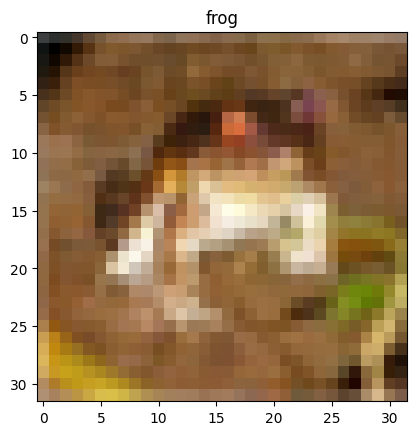

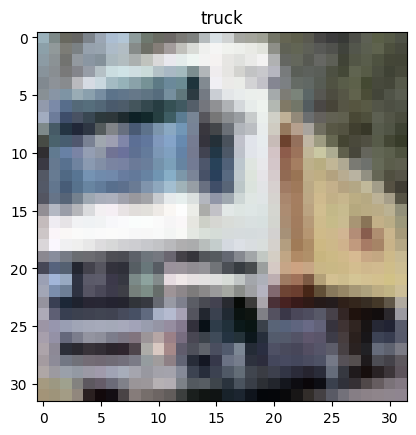

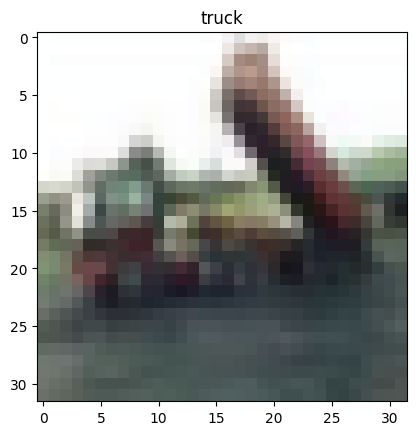

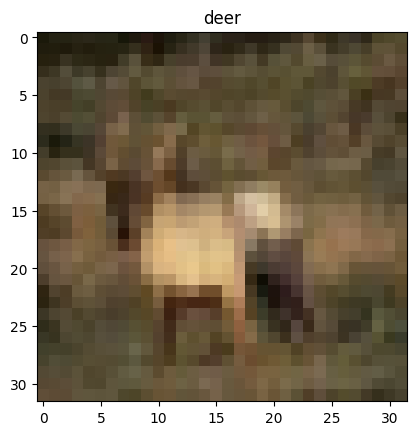

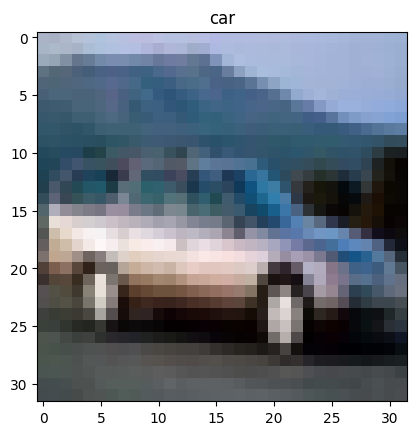

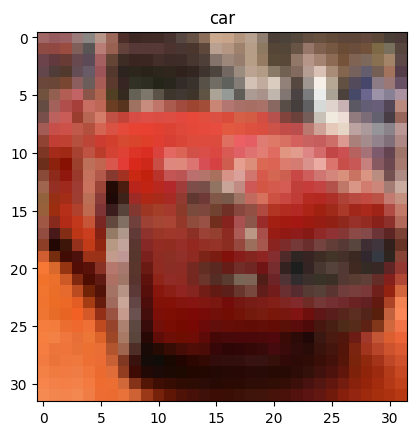

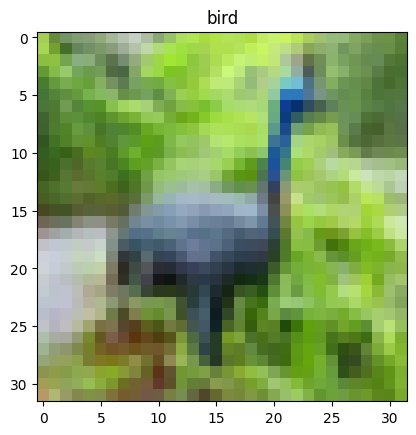

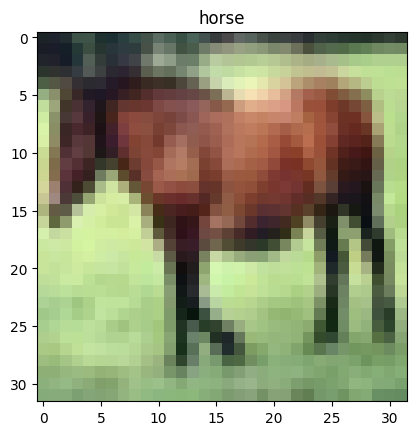

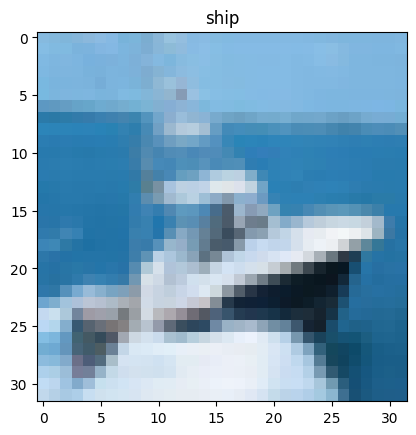

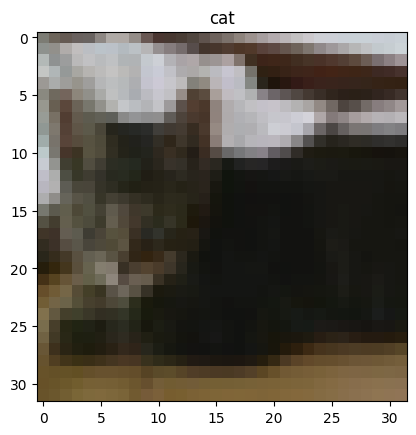

In [18]:
# Визуализируем данные из датасета

X_batch, y_batch = next(iter(vizualization_loader))

for x_item, y_item in zip(X_batch, y_batch):
    show_input(x_item,
           title=classes[y_item])

### 4. Архитектура Учителя и Студента

Определим большую модель Учителя и маленькую Студента.

In [19]:
from torchvision.models import resnet50, resnet18, ResNet50_Weights, ResNet18_Weights

In [20]:
# help(resnet50)

In [69]:
teacher_model = resnet50(weights= None)

# Загружаем веса
state_dict = torch.load('./resnet50_weights/resnet50-11ad3fa6.pth')

teacher_model.load_state_dict(state_dict)

# CIFAR-10 имеет 10 классов, поэтому нужно адаптировать последний слой сети
# (ResNet50 по умолчанию рассчитан на 1000 классов ImageNet.)
teacher_model.fc = nn.Linear(2048, 10)

In [70]:
teacher_model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [71]:
# student_model = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
student_model = resnet18(weights=None)

# Загружаем веса
state_dict = torch.load('./resnet18_weights/resnet18-f37072fd.pth')

student_model.load_state_dict(state_dict)

student_model.fc = nn.Linear(512, 10)

In [72]:
# student_model

#### 5. Функции обучения и валидации

In [73]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [74]:
criterion = nn.CrossEntropyLoss()

In [75]:
LEARNING_RATE = 0.001

teacher_optimizer = optim.AdamW(teacher_model.parameters(), 
                                lr=LEARNING_RATE)

student_optimizer = optim.AdamW(student_model.parameters(), 
                                lr=LEARNING_RATE)

In [76]:
# TensorBoard
writer = SummaryWriter(log_dir='runs/baseline')

In [32]:
!tensorboard --logdir=runs/baseline

/bin/bash: tensorboard: command not found


In [77]:
def train(model, num_epochs, train_loader, val_loader, optimizer, criterion, device, class_names):
    model.to(device)

    # История обучения
    history = {
        'train_loss': [],
        'val_loss': [],
        'val_acc': [],
        'val_precision': [],
        'val_recall': [],
        'val_f1': [],
        'total_time':0
    }

    total_start = time.time()

    for epoch in range(num_epochs):
        # ---------- ОБУЧЕНИЕ ----------
        model.train()
        running_loss = 0.0

        train_loop = tqdm(train_loader, desc=f"Epoch [{epoch+1}/{num_epochs}] (train)", leave=False)
        for inputs, targets in train_loop:
            inputs, targets = inputs.to(device), targets.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            train_loop.set_postfix(loss=loss.item())

        avg_train_loss = running_loss / len(train_loader)

        # ---------- ВАЛИДАЦИЯ ----------
        model.eval()
        val_loss = 0.0
        all_preds = []
        all_labels = []

        with torch.no_grad():
            val_loop = tqdm(val_loader, desc=f"Epoch [{epoch+1}/{num_epochs}] (val)", leave=False)
            for inputs, targets in val_loop:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                val_loss += loss.item()

                _, predicted = torch.max(outputs, 1)
                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(targets.cpu().numpy())

        avg_val_loss = val_loss / len(val_loader)
        val_accuracy = 100 * np.mean(np.array(all_preds) == np.array(all_labels))
        val_precision = precision_score(all_labels, all_preds, average='macro', zero_division=0)
        val_recall = recall_score(all_labels, all_preds, average='macro', zero_division=0)
        val_f1 = f1_score(all_labels, all_preds, average='macro', zero_division=0)

        # ---------- ЛОГИРОВАНИЕ ----------
        writer.add_scalar("Loss/Train", avg_train_loss, epoch)
        writer.add_scalar("Loss/Val", avg_val_loss, epoch)
        writer.add_scalar("Accuracy/Val", val_accuracy, epoch)
        writer.add_scalar("Precision/Val", val_precision, epoch)
        writer.add_scalar("Recall/Val", val_recall, epoch)
        writer.add_scalar("F1/Val", val_f1, epoch)

        # Добавим примеры изображений в TensorBoard (раз в 5 эпох)
        if epoch % 5 == 0:
            imgs_grid = torchvision.utils.make_grid(inputs[:8].cpu(), normalize=True)
            writer.add_image("Sample Images", imgs_grid, epoch)

        # ---------- СОХРАНЕНИЕ В ИСТОРИЮ ----------
        history['train_loss'].append(avg_train_loss)
        history['val_loss'].append(avg_val_loss)
        history['val_acc'].append(val_accuracy)
        history['val_precision'].append(val_precision)
        history['val_recall'].append(val_recall)
        history['val_f1'].append(val_f1)

        print(f"Epoch [{epoch+1}/{num_epochs}] "
              f"Train Loss: {avg_train_loss:.4f} | "
              f"Val Loss: {avg_val_loss:.4f} | "
              f"Val Acc: {val_accuracy:.2f}% | "
              f"Val Precision: {val_precision:.2f}% | "
              f"Val Recall: {val_recall:.2f}% | "
              f"Val F1: {val_f1:.3f}")

    total_time = time.time() - total_start
    
    history['total_time'] = total_time
    
    print(f"\nОбучение завершено за {total_time/60:.2f} мин ({total_time:.1f} сек)")
    
    writer.close()

    return history


In [78]:
def evaluate_metrics(model, dataloader, device, class_names, show_matrix=True, save_path=None):
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Accuracy
    acc = accuracy_score(all_labels, all_preds)
    

    # Classification report
    print("📊 Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=class_names))

    # Confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    print("🔹 Confusion Matrix:")
    # print(cm)

    # ----- Визуализация -----
    if show_matrix:
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=class_names,
                    yticklabels=class_names)
        plt.xlabel('Предсказанный класс')
        plt.ylabel('Истинный класс')
        plt.title(f'Confusion Matrix — Accuracy: {acc:.2f}')
        plt.tight_layout()

        if save_path:
            plt.savefig(save_path, dpi=300)
            print(f"✅ Матрица сохранена в {save_path}")
        plt.show()

    print(f"✅ Accuracy: {acc:.4f}")

    return {
        "accuracy": acc,
        # "top5_accuracy": top5_acc,
        "confusion_matrix": cm
    }

In [125]:
def summarize_history(history: dict, model_name: str = "ResNet18", method:str = None) -> dict:
    """
    Усредняет все значения истории обучения (кроме total_time)
    и добавляет имя модели.

    Args:
        history (dict): История обучения (train_loss, val_acc, total_time и т.д.)
        model_name (str): Название модели, которое будет добавлено в результат.

    Returns:
        dict: Словарь с усреднёнными метриками и именем модели.
    """
    averages = {
        k: round(np.mean(v), 3) if isinstance(v, list) else round(v, 3)
        for k, v in history.items()
    }

    averages["model"] = model_name
    averages["method"] = method
    return averages

### 6. BASELINE: Обучение модели

1. Обучить архитектуру, которая далее будет считаться Учителем.
2. Обучить архитектуру, которая далее будет считаться Студентом. Архитектура должна быть слабее Учителя.
3. Сравнить метрики.


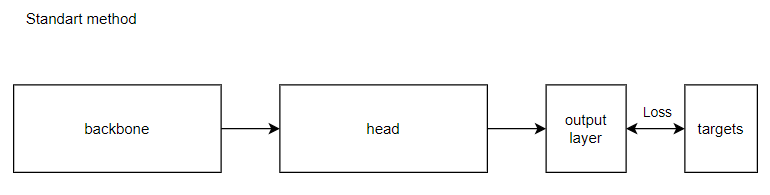

In [79]:
EPOCHS = 10

Обучим модель Учителя (архитектура ResNet50)

In [80]:
history = train(model = teacher_model, 
                num_epochs=EPOCHS,
                train_loader=train_loader,
                val_loader=test_loader,
                optimizer=teacher_optimizer,
                criterion=criterion,
                device=device,
                class_names=classes)


# Общее время: 66.32 мин (3979.0 сек) BATCH_SIZE = 10 EPOCHS = 40
# Общее время: 11.12 мин (667.0 сек)  BATCH_SIZE = 64 EPOCHS = 40 

Epoch [1/10] Train Loss: 0.8627 | Val Loss: 0.6149 | Val Acc: 80.26% | Val Precision: 0.81% | Val Recall: 0.80% | Val F1: 0.802


Epoch [2/10] Train Loss: 0.5116 | Val Loss: 0.5675 | Val Acc: 81.21% | Val Precision: 0.82% | Val Recall: 0.81% | Val F1: 0.813


Epoch [3/10] Train Loss: 0.3895 | Val Loss: 0.5742 | Val Acc: 81.44% | Val Precision: 0.82% | Val Recall: 0.81% | Val F1: 0.815


Epoch [4/10] Train Loss: 0.3094 | Val Loss: 0.6127 | Val Acc: 81.12% | Val Precision: 0.81% | Val Recall: 0.81% | Val F1: 0.811


Epoch [5/10] Train Loss: 0.2571 | Val Loss: 0.5721 | Val Acc: 82.90% | Val Precision: 0.83% | Val Recall: 0.83% | Val F1: 0.830


Epoch [6/10] Train Loss: 0.2161 | Val Loss: 0.6147 | Val Acc: 82.80% | Val Precision: 0.83% | Val Recall: 0.83% | Val F1: 0.828


Epoch [7/10] Train Loss: 0.1844 | Val Loss: 0.7102 | Val Acc: 80.56% | Val Precision: 0.81% | Val Recall: 0.81% | Val F1: 0.806


Epoch [8/10] Train Loss: 0.1649 | Val Loss: 0.6750 | Val Acc: 82.85% | Val Precision: 0.83% | Val Recall: 0.83% | Val F1: 0.829


Epoch [9/10] Train Loss: 0.1351 | Val Loss: 0.7392 | Val Acc: 82.06% | Val Precision: 0.83% | Val Recall: 0.82% | Val F1: 0.821


Epoch [10/10] Train Loss: 0.1448 | Val Loss: 0.6977 | Val Acc: 82.28% | Val Precision: 0.82% | Val Recall: 0.82% | Val F1: 0.822

Обучение завершено за 2.81 мин (168.8 сек)


In [67]:
history

{'train_loss': [2.335656766086588,
  2.335656766086588,
  2.335656766086588,
  2.335656766086588,
  2.335656766086588,
  2.335656766086588,
  2.335656766086588,
  2.335656766086588,
  2.335656766086588,
  2.335656766086588],
 'val_loss': [2.4340943287891945,
  2.4340943287891945,
  2.4340943287891945,
  2.4340943287891945,
  2.4340943287891945,
  2.4340943287891945,
  2.4340943287891945,
  2.4340943287891945,
  2.4340943287891945,
  2.4340943287891945],
 'val_acc': [np.float64(10.82),
  np.float64(10.82),
  np.float64(10.82),
  np.float64(10.82),
  np.float64(10.82),
  np.float64(10.82),
  np.float64(10.82),
  np.float64(10.82),
  np.float64(10.82),
  np.float64(10.82)],
 'val_precision': [np.float64(0.10842344779368587),
  np.float64(0.10842344779368587),
  np.float64(0.10842344779368587),
  np.float64(0.10842344779368587),
  np.float64(0.10842344779368587),
  np.float64(0.10842344779368587),
  np.float64(0.10842344779368587),
  np.float64(0.10842344779368587),
  np.float64(0.10842344

In [127]:
avg_history_teacher = summarize_history(history, model_name="ResNet50", method = 'Стандартное обучение')
avg_history_teacher

{'train_loss': np.float64(0.318),
 'val_loss': np.float64(0.638),
 'val_acc': np.float64(81.748),
 'val_precision': np.float64(0.823),
 'val_recall': np.float64(0.817),
 'val_f1': np.float64(0.818),
 'total_time': 168.796,
 'model': 'ResNet50',
 'method': 'Стандартное обучение'}

In [84]:
# torch.save(teacher_model.state_dict(), "./experiments_hw4/model_weights_TEACHER_standard_method.pth")

# teacher_model.load_state_dict(torch.load("./experiments_hw4/model_weights_TEACHER_standard_method.pth"))
# teacher_model.eval()  

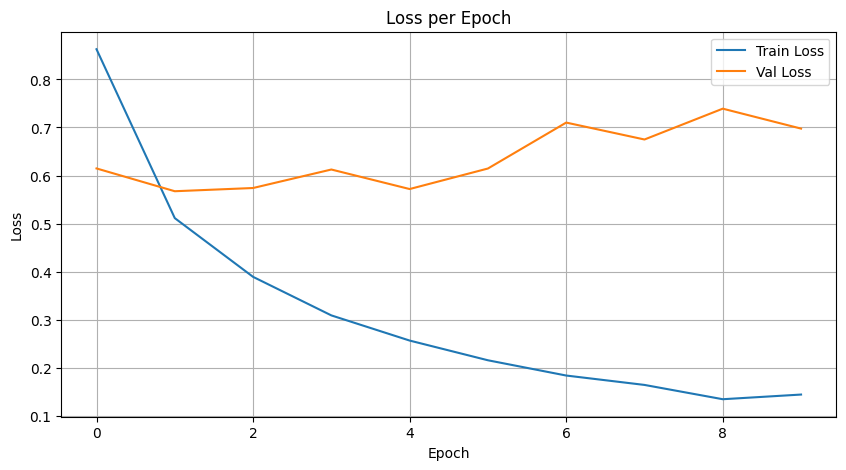

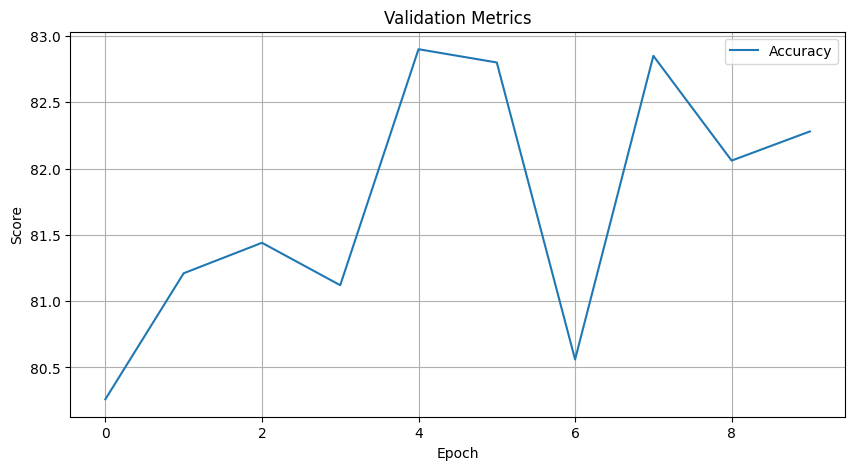

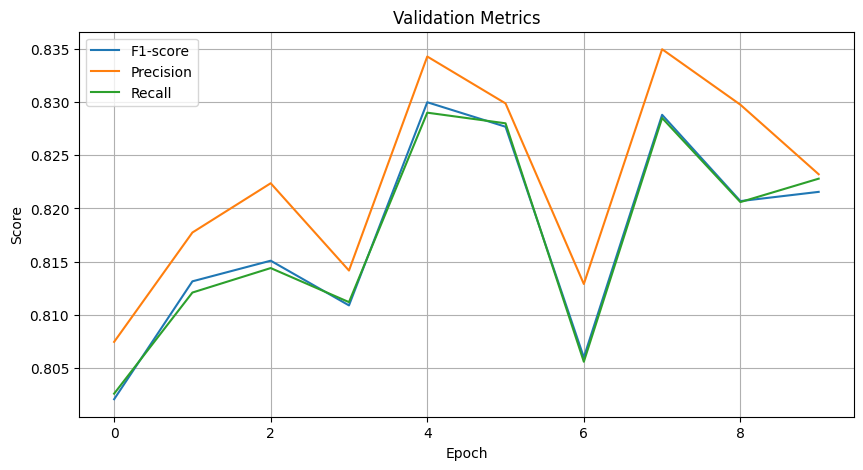

In [82]:
plt.figure(figsize=(10,5))
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Val Loss')
plt.legend()
plt.grid()
plt.title('Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

plt.figure(figsize=(10,5))
plt.plot(history['val_acc'], label='Accuracy')
plt.legend()
plt.grid()
plt.title('Validation Metrics')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.show()


plt.figure(figsize=(10,5))
plt.plot(history['val_f1'], label='F1-score')
plt.plot(history['val_precision'], label='Precision')
plt.plot(history['val_recall'], label='Recall')
plt.legend()
plt.grid()
plt.title('Validation Metrics')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.show()

📊 Classification Report:
              precision    recall  f1-score   support

       plane       0.79      0.89      0.84      1000
         car       0.91      0.89      0.90      1000
        bird       0.80      0.78      0.79      1000
         cat       0.72      0.63      0.67      1000
        deer       0.82      0.76      0.79      1000
         dog       0.75      0.73      0.74      1000
        frog       0.79      0.90      0.84      1000
       horse       0.85      0.89      0.87      1000
        ship       0.95      0.86      0.90      1000
       truck       0.85      0.89      0.87      1000

    accuracy                           0.82     10000
   macro avg       0.82      0.82      0.82     10000
weighted avg       0.82      0.82      0.82     10000

🔹 Confusion Matrix:


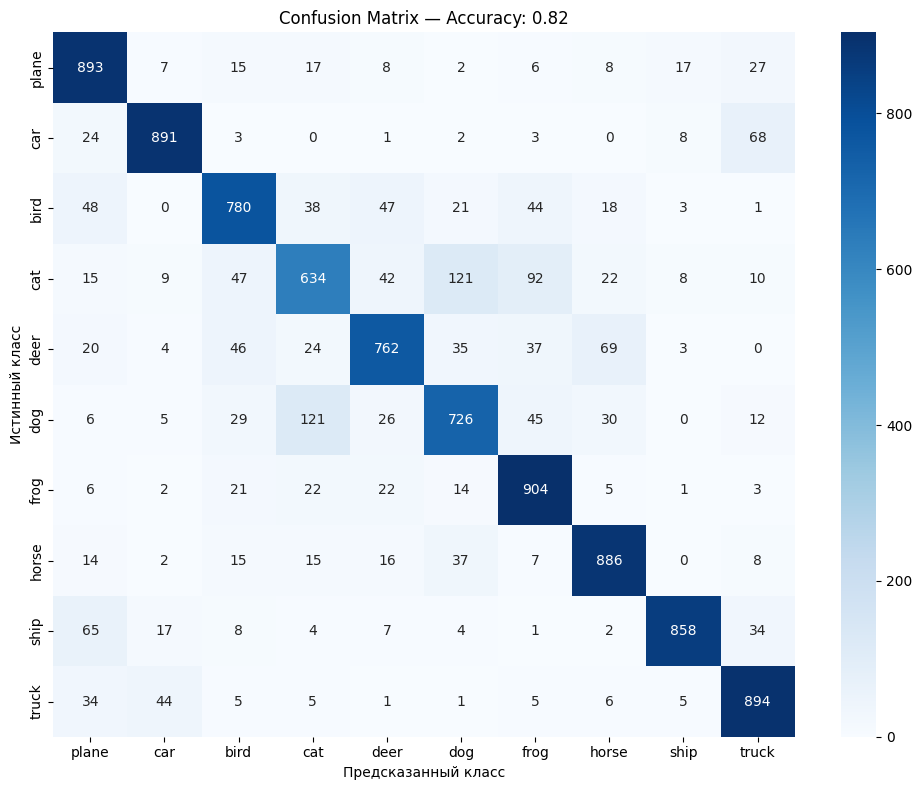

✅ Accuracy: 0.8228


{'accuracy': 0.8228,
 'confusion_matrix': array([[893,   7,  15,  17,   8,   2,   6,   8,  17,  27],
        [ 24, 891,   3,   0,   1,   2,   3,   0,   8,  68],
        [ 48,   0, 780,  38,  47,  21,  44,  18,   3,   1],
        [ 15,   9,  47, 634,  42, 121,  92,  22,   8,  10],
        [ 20,   4,  46,  24, 762,  35,  37,  69,   3,   0],
        [  6,   5,  29, 121,  26, 726,  45,  30,   0,  12],
        [  6,   2,  21,  22,  22,  14, 904,   5,   1,   3],
        [ 14,   2,  15,  15,  16,  37,   7, 886,   0,   8],
        [ 65,  17,   8,   4,   7,   4,   1,   2, 858,  34],
        [ 34,  44,   5,   5,   1,   1,   5,   6,   5, 894]])}

In [83]:
evaluate_metrics(teacher_model, 
                 test_loader, 
                 device, 
                 classes)

Обучим модель Студента (архитектура ResNet18)

In [85]:
history_student = train(model = student_model, 
                        num_epochs=EPOCHS,
                        train_loader=train_loader,
                        val_loader=test_loader,
                        optimizer=student_optimizer,
                        criterion=criterion,
                        device=device,
                        class_names=classes)
# Общее время: 29.31 мин (1758.6 сек) BATCH_SIZE = 10 EPOCHS = 40
# Общее время: 2.56 мин (153.3 сек) BATCH_SIZE = 64 EPOCHS = 40

Epoch [1/10] Train Loss: 0.9691 | Val Loss: 0.8200 | Val Acc: 72.93% | Val Precision: 0.74% | Val Recall: 0.73% | Val F1: 0.725


Epoch [2/10] Train Loss: 0.6551 | Val Loss: 0.7194 | Val Acc: 76.83% | Val Precision: 0.77% | Val Recall: 0.77% | Val F1: 0.765


Epoch [3/10] Train Loss: 0.5002 | Val Loss: 0.6731 | Val Acc: 78.38% | Val Precision: 0.79% | Val Recall: 0.78% | Val F1: 0.784


Epoch [4/10] Train Loss: 0.3936 | Val Loss: 0.7383 | Val Acc: 78.02% | Val Precision: 0.78% | Val Recall: 0.78% | Val F1: 0.779


Epoch [5/10] Train Loss: 0.3081 | Val Loss: 0.8527 | Val Acc: 76.34% | Val Precision: 0.78% | Val Recall: 0.76% | Val F1: 0.764


Epoch [6/10] Train Loss: 0.2495 | Val Loss: 0.8450 | Val Acc: 78.15% | Val Precision: 0.79% | Val Recall: 0.78% | Val F1: 0.781


Epoch [7/10] Train Loss: 0.2014 | Val Loss: 0.8434 | Val Acc: 78.48% | Val Precision: 0.79% | Val Recall: 0.78% | Val F1: 0.785


Epoch [8/10] Train Loss: 0.1629 | Val Loss: 0.8501 | Val Acc: 79.00% | Val Precision: 0.80% | Val Recall: 0.79% | Val F1: 0.791


Epoch [9/10] Train Loss: 0.1342 | Val Loss: 0.9530 | Val Acc: 78.14% | Val Precision: 0.79% | Val Recall: 0.78% | Val F1: 0.784


Epoch [10/10] Train Loss: 0.1227 | Val Loss: 0.8387 | Val Acc: 79.62% | Val Precision: 0.80% | Val Recall: 0.80% | Val F1: 0.798

Обучение завершено за 1.32 мин (79.2 сек)


In [88]:
history_student

{'train_loss': [0.9691427891592845,
  0.6551125054164311,
  0.5002031692725313,
  0.39358568856554565,
  0.30814239158845314,
  0.24948830996661464,
  0.20138234401698155,
  0.16289638896303638,
  0.13420258840674634,
  0.12270097054607804],
 'val_loss': [0.8200003776201017,
  0.719433282211328,
  0.6731166814922527,
  0.7383154492089703,
  0.85273935584126,
  0.845008709153552,
  0.8434183557701719,
  0.8501307543865435,
  0.9529948209881023,
  0.8387240272039062],
 'val_acc': [np.float64(72.92999999999999),
  np.float64(76.83),
  np.float64(78.38000000000001),
  np.float64(78.02),
  np.float64(76.34),
  np.float64(78.14999999999999),
  np.float64(78.48),
  np.float64(79.0),
  np.float64(78.14),
  np.float64(79.62)],
 'val_precision': [np.float64(0.7360235395451679),
  np.float64(0.7705899673617387),
  np.float64(0.7883514085542627),
  np.float64(0.7838171862418246),
  np.float64(0.7767737754067474),
  np.float64(0.7920522315775701),
  np.float64(0.7872192204154722),
  np.float64(0.79

In [126]:
avg_history_student = summarize_history(history_student, model_name="ResNet18", method = 'Стандартное обучение')
avg_history_student

{'train_loss': np.float64(0.37),
 'val_loss': np.float64(0.813),
 'val_acc': np.float64(77.589),
 'val_precision': np.float64(0.783),
 'val_recall': np.float64(0.776),
 'val_f1': np.float64(0.775),
 'total_time': 79.163,
 'model': 'ResNet18',
 'method': 'Стандартное обучение'}

In [86]:
torch.save(student_model.state_dict(), "./experiments_hw4/model_weights_STUDENT_standard_method.pth")

# student_model.load_state_dict(torch.load("./experiments_hw4/model_weights_STUDENT_standard_method.pth"))
# student_model.eval() 

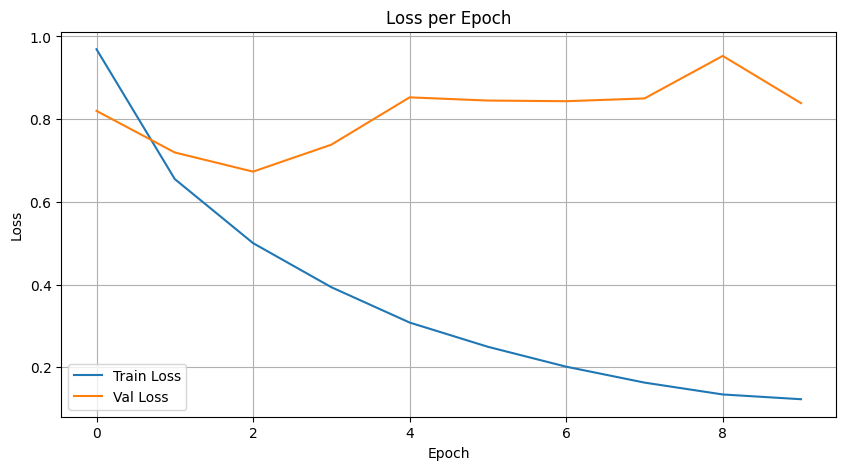

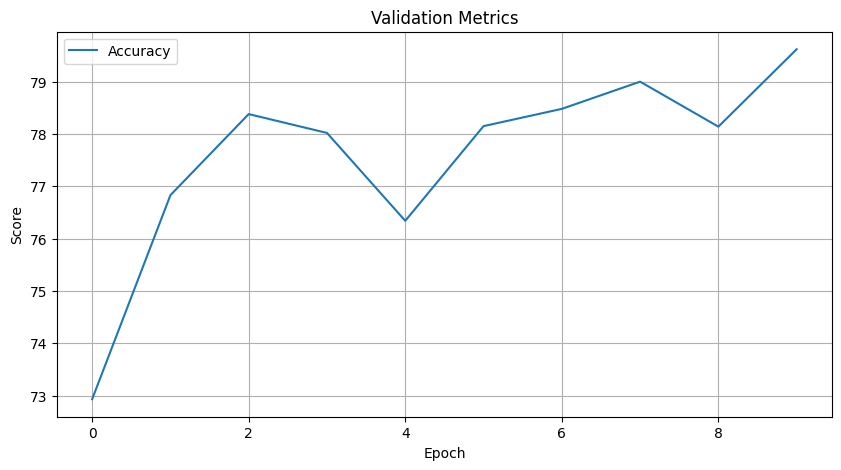

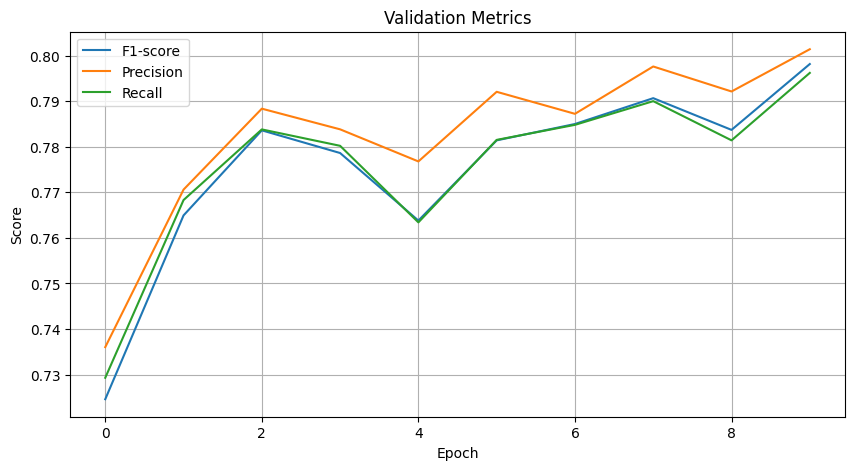

In [130]:
plt.figure(figsize=(10,5))
plt.plot(history_student['train_loss'], label='Train Loss')
plt.plot(history_student['val_loss'], label='Val Loss')
plt.legend()
plt.grid()
plt.title('Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

plt.figure(figsize=(10,5))
plt.plot(history_student['val_acc'], label='Accuracy')
plt.legend()
plt.grid()
plt.title('Validation Metrics')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.show()


plt.figure(figsize=(10,5))
plt.plot(history_student['val_f1'], label='F1-score')
plt.plot(history_student['val_precision'], label='Precision')
plt.plot(history_student['val_recall'], label='Recall')
plt.legend()
plt.grid()
plt.title('Validation Metrics')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.show()

📊 Classification Report:
              precision    recall  f1-score   support

       plane       0.81      0.83      0.82      1000
         car       0.90      0.85      0.88      1000
        bird       0.76      0.74      0.75      1000
         cat       0.60      0.64      0.62      1000
        deer       0.78      0.80      0.79      1000
         dog       0.65      0.73      0.69      1000
        frog       0.83      0.85      0.84      1000
       horse       0.87      0.82      0.85      1000
        ship       0.90      0.87      0.88      1000
       truck       0.89      0.83      0.86      1000

    accuracy                           0.80     10000
   macro avg       0.80      0.80      0.80     10000
weighted avg       0.80      0.80      0.80     10000

🔹 Confusion Matrix:


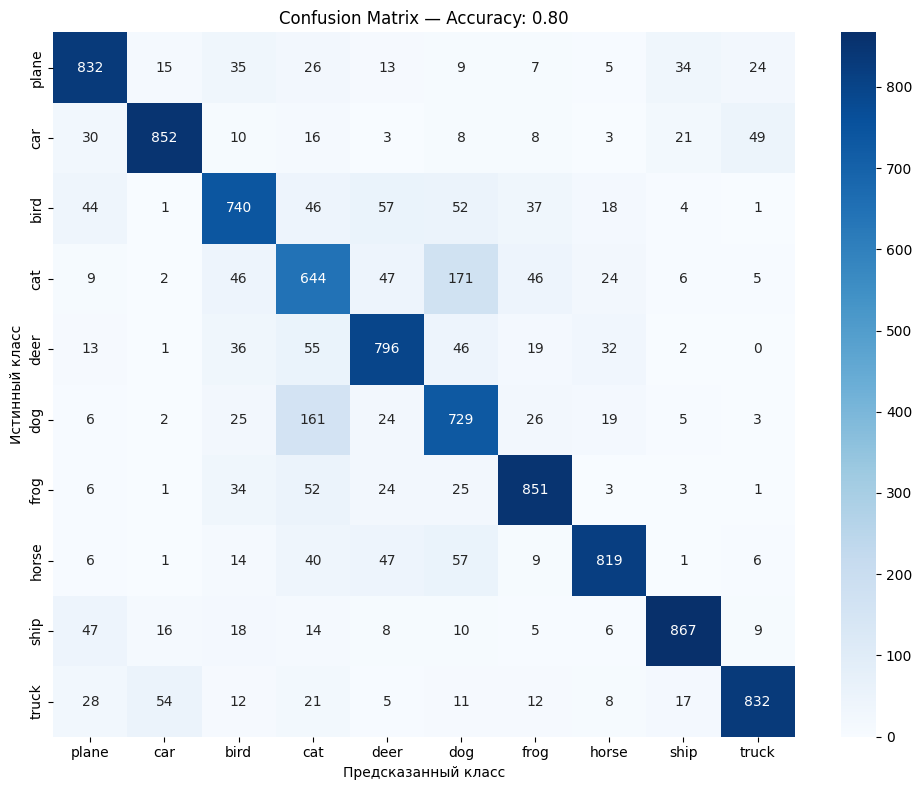

✅ Accuracy: 0.7962


{'accuracy': 0.7962,
 'confusion_matrix': array([[832,  15,  35,  26,  13,   9,   7,   5,  34,  24],
        [ 30, 852,  10,  16,   3,   8,   8,   3,  21,  49],
        [ 44,   1, 740,  46,  57,  52,  37,  18,   4,   1],
        [  9,   2,  46, 644,  47, 171,  46,  24,   6,   5],
        [ 13,   1,  36,  55, 796,  46,  19,  32,   2,   0],
        [  6,   2,  25, 161,  24, 729,  26,  19,   5,   3],
        [  6,   1,  34,  52,  24,  25, 851,   3,   3,   1],
        [  6,   1,  14,  40,  47,  57,   9, 819,   1,   6],
        [ 47,  16,  18,  14,   8,  10,   5,   6, 867,   9],
        [ 28,  54,  12,  21,   5,  11,  12,   8,  17, 832]])}

In [87]:
evaluate_metrics(student_model, 
                 test_loader, 
                 device, 
                 classes)

In [135]:
df_standard_method = pd.DataFrame([avg_history_teacher, avg_history_student])
df_standard_method

,train_loss,val_loss,val_acc,val_precision,val_recall,val_f1,total_time,model,method
0,0.318,0.638,81.748,0.823,0.817,0.818,168.796,ResNet50,Стандартное обучение
1,0.370,0.813,77.589,0.783,0.776,0.775,79.163,ResNet18,Стандартное обучение


### 7. Эксперимент 1 - Дистилляция логитов

1. Измените тренировочный цикл так, чтобы параллельно в две архитектуры подавались семплы, при этом в Учителе должно быть отколючено обновление градиентов (torch.no_grad()).
2. Изменить функцию ошибки.


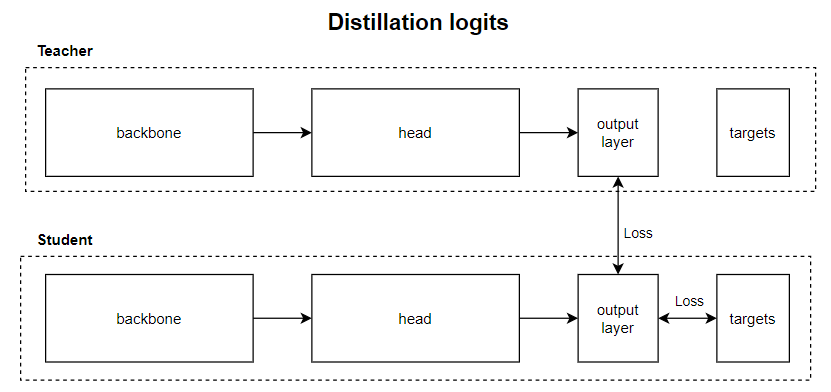


## Суть дистилляции логитов

Студент обучается не только по истинным меткам (labels), но и по “мягким” вероятностям Учителя — то есть по его логитам (до Softmax).

---

## Что нужно изменить

### Подавать входы **в обе модели одновременно**

* Учитель — в `torch.no_grad()` (градиенты не считаем).
* Студент — обучается по новой функции потерь.

### Изменить **функцию ошибки (distillation loss)**

Формула потерь:


$$L = (1 - \alpha) \cdot CE(y_s, y_{true}) + \alpha \cdot T^2 \cdot KLDivLoss(p_s^T, p_t^T)$$


где:

* ( $CE$ ) — обычная кросс-энтропия;
* ( $KLDivLoss$ ) — расхождение Кульбака–Лейблера между распределениями Учителя и Студента;
* ( $T$ ) — температура (обычно 2–5);
* ( $\alpha$ ) — коэффициент, задающий баланс (0.5 — часто оптимален).

---

In [112]:
teacher_model = resnet50(weights= None)

# Загружаем веса
state_dict = torch.load('./resnet50_weights/resnet50-11ad3fa6.pth')

teacher_model.load_state_dict(state_dict)

# CIFAR-10 имеет 10 классов, поэтому нужно адаптировать последний слой сети
# (ResNet50 по умолчанию рассчитан на 1000 классов ImageNet.)
teacher_model.fc = nn.Linear(2048, 10)

In [113]:
student_model = resnet18(weights=None)

# Загружаем веса
state_dict = torch.load('./resnet18_weights/resnet18-f37072fd.pth')

student_model.load_state_dict(state_dict)

student_model.fc = nn.Linear(512, 10)

In [114]:
LEARNING_RATE = 0.001

teacher_optimizer = optim.AdamW(teacher_model.parameters(), 
                                lr=LEARNING_RATE)

student_optimizer = optim.AdamW(student_model.parameters(), 
                                lr=LEARNING_RATE)

In [115]:
EPOCHS = 10

In [116]:
def distillation_loss(student_logits, teacher_logits, true_labels, T=4.0, alpha=0.5):
    """
    Функция потерь для дистилляции логитов.
    """
    # Обычная кросс-энтропия по реальным меткам
    ce_loss = F.cross_entropy(student_logits, true_labels)
    
    # "Мягкие" распределения вероятностей
    p_teacher = F.log_softmax(teacher_logits / T, dim=1)
    p_student = F.softmax(student_logits / T, dim=1)
    
    # KLDivLoss между распределениями
    kl_loss = F.kl_div(p_teacher, p_student, reduction="batchmean") * (T * T)
    
    # Комбинация
    return (1 - alpha) * ce_loss + alpha * kl_loss

In [117]:
def train_distill(
                teacher_model,
                student_model,
                device,
                train_loader,
                val_loader,
                optimizer,
                num_epochs=10,
                T=4.0,
                alpha=0.5,
                writer=None
            ):
    """
    Обучение студента с дистилляцией знаний.
    """

    teacher_model.to(device)
    student_model.to(device)
    teacher_model.eval()  # Учитель не обучается

    history = {
        'train_loss': [],
        'val_loss': [],
        'val_acc': [],
        'val_precision': [],
        'val_recall': [],
        'val_f1': [],
        'total_time': 0
    }

    total_start = time.time()

    for epoch in range(num_epochs):
        # ---------- ОБУЧЕНИЕ ----------
        student_model.train()
        running_loss = 0.0

        train_loop = tqdm(train_loader, desc=f"Epoch [{epoch+1}/{num_epochs}] (train)", leave=False)
        
        for inputs, targets in train_loop:
            inputs, targets = inputs.to(device), targets.to(device)

            optimizer.zero_grad()

            with torch.no_grad():
                teacher_outputs = teacher_model(inputs)

            student_outputs = student_model(inputs)

            loss = distillation_loss(student_outputs, teacher_outputs, targets, T=T, alpha=alpha)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            train_loop.set_postfix(loss=loss.item())

        avg_train_loss = running_loss / len(train_loader)

        # ---------- ВАЛИДАЦИЯ ----------
        student_model.eval()
        val_loss = 0.0
        all_preds, all_labels = [], []

        with torch.no_grad():
            val_loop = tqdm(val_loader, desc=f"Epoch [{epoch+1}/{num_epochs}] (val)", leave=False)
            for inputs, targets in val_loop:
                inputs, targets = inputs.to(device), targets.to(device)
                teacher_outputs = teacher_model(inputs)
                student_outputs = student_model(inputs)

                loss = distillation_loss(student_outputs, teacher_outputs, targets, T=T, alpha=alpha)
                val_loss += loss.item()

                _, predicted = torch.max(student_outputs, 1)
                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(targets.cpu().numpy())

        avg_val_loss = val_loss / len(val_loader)
        val_accuracy = 100 * np.mean(np.array(all_preds) == np.array(all_labels))
        val_precision = precision_score(all_labels, all_preds, average='macro', zero_division=0)
        val_recall = recall_score(all_labels, all_preds, average='macro', zero_division=0)
        val_f1 = f1_score(all_labels, all_preds, average='macro', zero_division=0)

        # ---------- ЛОГИРОВАНИЕ ----------
        if writer is not None:
            writer.add_scalar("Loss/Train", avg_train_loss, epoch)
            writer.add_scalar("Loss/Val", avg_val_loss, epoch)
            writer.add_scalar("Accuracy/Val", val_accuracy, epoch)
            writer.add_scalar("Precision/Val", val_precision, epoch)
            writer.add_scalar("Recall/Val", val_recall, epoch)
            writer.add_scalar("F1/Val", val_f1, epoch)

            # Добавим примеры изображений раз в 5 эпох
            if epoch % 5 == 0:
                imgs_grid = torchvision.utils.make_grid(inputs[:8].cpu(), normalize=True)
                writer.add_image("Sample Images", imgs_grid, epoch)

        # ---------- СОХРАНЕНИЕ В ИСТОРИЮ ----------
        history['train_loss'].append(avg_train_loss)
        history['val_loss'].append(avg_val_loss)
        history['val_acc'].append(val_accuracy)
        history['val_precision'].append(val_precision)
        history['val_recall'].append(val_recall)
        history['val_f1'].append(val_f1)

        print(f"Epoch [{epoch+1}/{num_epochs}] "
              f"Train Loss: {avg_train_loss:.4f} | "
              f"Val Loss: {avg_val_loss:.4f} | "
              f"Val Acc: {val_accuracy:.2f}% | "
              f"Val Precision: {val_precision:.2f}% | "
              f"Val Recall: {val_recall:.2f}% | "
              f"Val F1: {val_f1:.3f}")

    total_time = time.time() - total_start
    history['total_time'] = total_time

    print(f"\nДистилляция завершена за {total_time/60:.2f} мин ({total_time:.1f} сек)")

    if writer is not None:
        writer.close()

    return history

In [118]:
history_student_distill = train_distill(
                                        teacher_model=teacher_model,
                                        student_model=student_model,
                                        device=device,
                                        train_loader=train_loader,
                                        val_loader=test_loader,
                                        optimizer=student_optimizer,
                                        num_epochs=EPOCHS,
                                        T=4.0,       # температура
                                        alpha=0.5,    # баланс между CE и KL
                                        writer=writer
                                    )

Epoch [1/10] Train Loss: 0.9119 | Val Loss: 0.9579 | Val Acc: 71.58% | Val Precision: 0.72% | Val Recall: 0.72% | Val F1: 0.710


Epoch [2/10] Train Loss: 0.8413 | Val Loss: 0.8298 | Val Acc: 73.96% | Val Precision: 0.74% | Val Recall: 0.74% | Val F1: 0.735


Epoch [3/10] Train Loss: 0.7930 | Val Loss: 0.8594 | Val Acc: 71.07% | Val Precision: 0.75% | Val Recall: 0.71% | Val F1: 0.704


Epoch [4/10] Train Loss: 0.7533 | Val Loss: 0.8000 | Val Acc: 78.36% | Val Precision: 0.79% | Val Recall: 0.78% | Val F1: 0.782


Epoch [5/10] Train Loss: 0.7281 | Val Loss: 0.8207 | Val Acc: 78.89% | Val Precision: 0.79% | Val Recall: 0.79% | Val F1: 0.787


Epoch [6/10] Train Loss: 0.6940 | Val Loss: 0.8096 | Val Acc: 78.63% | Val Precision: 0.79% | Val Recall: 0.79% | Val F1: 0.787


Epoch [7/10] Train Loss: 0.7119 | Val Loss: 0.8057 | Val Acc: 78.74% | Val Precision: 0.80% | Val Recall: 0.79% | Val F1: 0.790


Epoch [8/10] Train Loss: 0.6740 | Val Loss: 0.7883 | Val Acc: 80.12% | Val Precision: 0.81% | Val Recall: 0.80% | Val F1: 0.803


Epoch [9/10] Train Loss: 0.6507 | Val Loss: 0.8143 | Val Acc: 79.23% | Val Precision: 0.80% | Val Recall: 0.79% | Val F1: 0.791


Epoch [10/10] Train Loss: 0.6461 | Val Loss: 0.8407 | Val Acc: 77.97% | Val Precision: 0.79% | Val Recall: 0.78% | Val F1: 0.780

Дистилляция завершена за 2.03 мин (121.9 сек)


In [129]:
avп_history_student_distill = summarize_history(history_student_distill, model_name="ResNet18", method = 'Дистилляция логитов')
avп_history_student_distill

{'train_loss': np.float64(0.74),
 'val_loss': np.float64(0.833),
 'val_acc': np.float64(76.855),
 'val_precision': np.float64(0.776),
 'val_recall': np.float64(0.769),
 'val_f1': np.float64(0.767),
 'total_time': 121.936,
 'model': 'ResNet18',
 'method': 'Дистилляция логитов'}

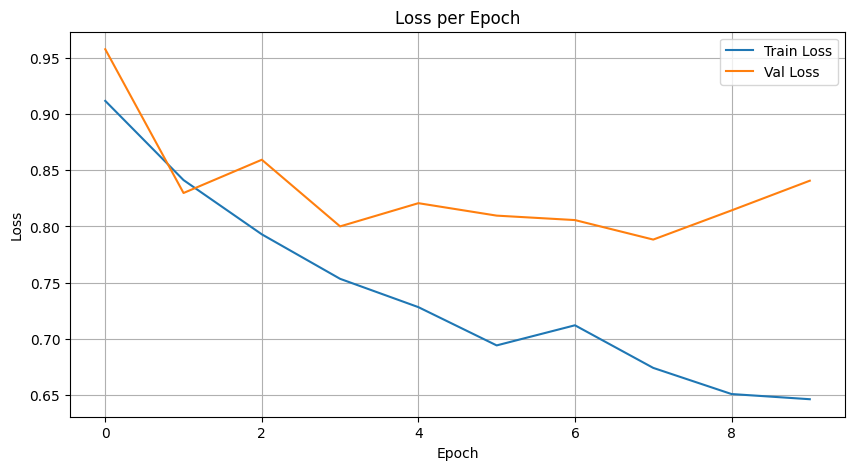

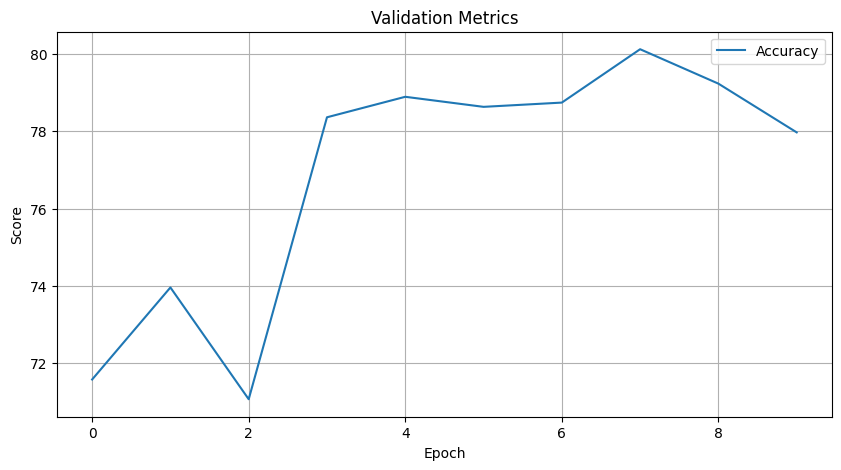

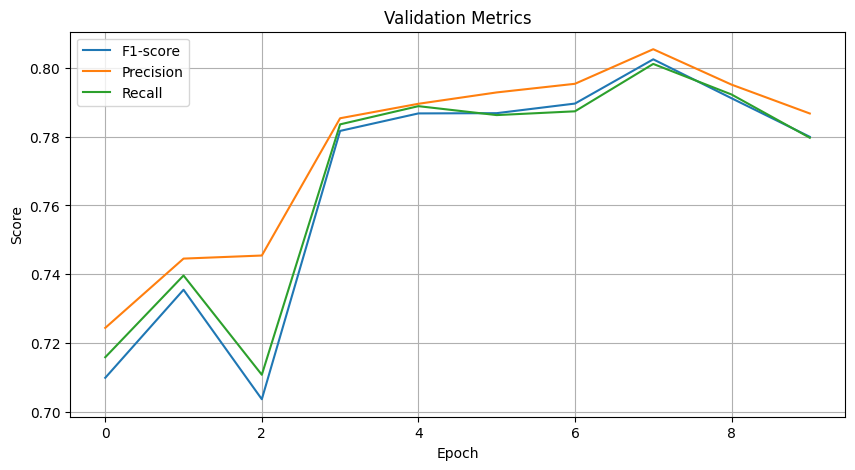

In [131]:
plt.figure(figsize=(10,5))
plt.plot(history_student_distill['train_loss'], label='Train Loss')
plt.plot(history_student_distill['val_loss'], label='Val Loss')
plt.legend()
plt.grid()
plt.title('Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

plt.figure(figsize=(10,5))
plt.plot(history_student_distill['val_acc'], label='Accuracy')
plt.legend()
plt.grid()
plt.title('Validation Metrics')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.show()


plt.figure(figsize=(10,5))
plt.plot(history_student_distill['val_f1'], label='F1-score')
plt.plot(history_student_distill['val_precision'], label='Precision')
plt.plot(history_student_distill['val_recall'], label='Recall')
plt.legend()
plt.grid()
plt.title('Validation Metrics')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.show()

📊 Classification Report:
              precision    recall  f1-score   support

       plane       0.72      0.85      0.78      1000
         car       0.91      0.85      0.88      1000
        bird       0.79      0.70      0.74      1000
         cat       0.59      0.69      0.64      1000
        deer       0.76      0.79      0.77      1000
         dog       0.80      0.61      0.69      1000
        frog       0.80      0.88      0.84      1000
       horse       0.83      0.83      0.83      1000
        ship       0.79      0.81      0.80      1000
       truck       0.89      0.78      0.83      1000

    accuracy                           0.78     10000
   macro avg       0.79      0.78      0.78     10000
weighted avg       0.79      0.78      0.78     10000

🔹 Confusion Matrix:


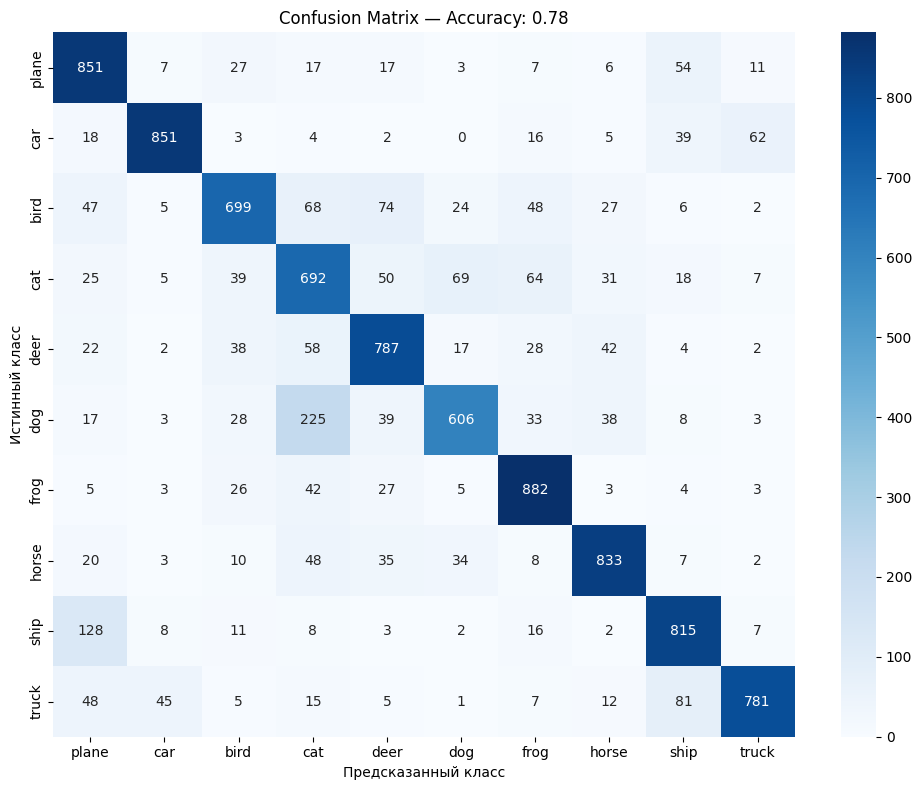

✅ Accuracy: 0.7797


{'accuracy': 0.7797,
 'confusion_matrix': array([[851,   7,  27,  17,  17,   3,   7,   6,  54,  11],
        [ 18, 851,   3,   4,   2,   0,  16,   5,  39,  62],
        [ 47,   5, 699,  68,  74,  24,  48,  27,   6,   2],
        [ 25,   5,  39, 692,  50,  69,  64,  31,  18,   7],
        [ 22,   2,  38,  58, 787,  17,  28,  42,   4,   2],
        [ 17,   3,  28, 225,  39, 606,  33,  38,   8,   3],
        [  5,   3,  26,  42,  27,   5, 882,   3,   4,   3],
        [ 20,   3,  10,  48,  35,  34,   8, 833,   7,   2],
        [128,   8,  11,   8,   3,   2,  16,   2, 815,   7],
        [ 48,  45,   5,  15,   5,   1,   7,  12,  81, 781]])}

In [132]:
evaluate_metrics(student_model, 
                 test_loader, 
                 device, 
                 classes)

In [136]:
df_result = pd.concat([df_standard_method, pd.DataFrame([avп_history_student_distill])], ignore_index=True)
df_result

,train_loss,val_loss,val_acc,val_precision,val_recall,val_f1,total_time,model,method
0,0.318,0.638,81.748,0.823,0.817,0.818,168.796,ResNet50,Стандартное обучение
1,0.370,0.813,77.589,0.783,0.776,0.775,79.163,ResNet18,Стандартное обучение
2,0.740,0.833,76.855,0.776,0.769,0.767,121.936,ResNet18,Дистилляция логитов
